# --------------------- Time for time series -  Structural Changes ---------------------

__Context__  
  
Structural changes are a big topic in time series analysis and will have a large effect on the quality of your predictions. A structural change occurs when an external factor changes the reality of your use case significantly. This is reflected in completely different patterns in the data and this means previously built models are rendered obsolete. You will have to adapt and retrain your model to the new reality and maybe even change the training data entirely. In traditional time series analysis you would typically first build a model and then use and monitor that model over time. Once model drift is observed, the models would typically be retrained and the process continues. 

Since TIM is so effective at building models, we are not constrained to the complexities of model building, allowing us to continuously retrain a new model at every prediction. This will help us capture the latest patterns in the data an remain adaptable to structural changes whereas other approach will lose accuracy. This analysis will show you exactly how.

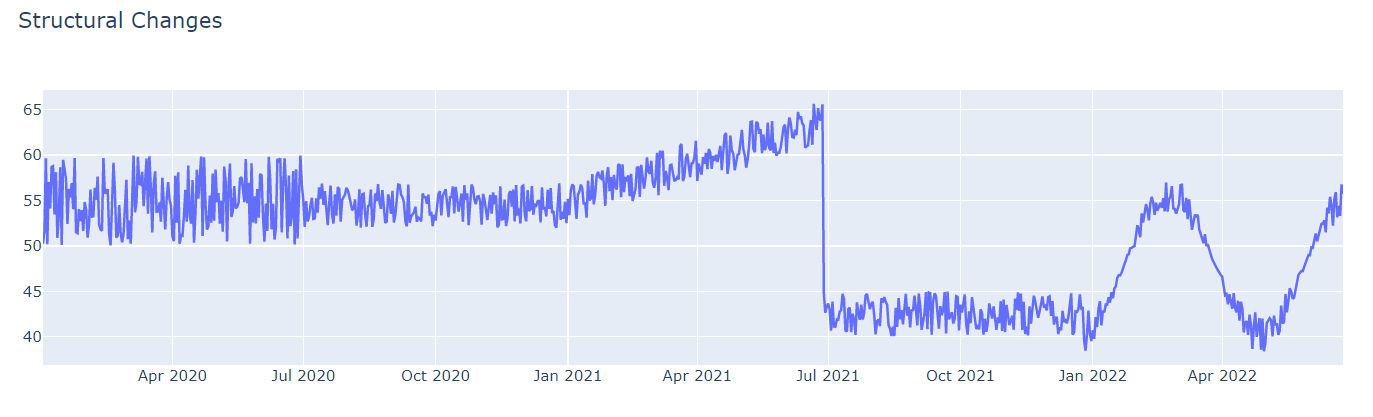

__Example__
  
A prime example of a structural change is the Covid pandemic which dramatically changed behavioral patterns across many industries. In this example we'll have a look at how the pandemic has shifted our energy consumption patterns.
We will bring the following data together: 
- Electricity grid load data in Belgium sourced from https://transparency.entsoe.eu/.
- Weather data sourced from: https://openweathermap.org/
- Public holiday information  
  
This will help us build an accurate model for predicting energy consumption. With this data we will be able to see the effect of a structural change.

__Objective__
  
In this notebook we will use TIM to take two approaches. Firstly, we'll simulate a continuous retraining process by providing TIM with an initial dataset and updating this with 1 day of extra data for the simulation horizon. We will then build models on each of these simulated datasets. This replicates a real production scenario with TIM.  
The second approach replicates traditional forecasting methods where no continuous retraining is viable. We will still use TIM for the model building and predictions however only 1 model will be built on the initial dataset, and for all other dates in the simulation horizon, we will use that same model. 
  
This will allow us to show the need for continuous retraining to remain adaptable to structural changes. 

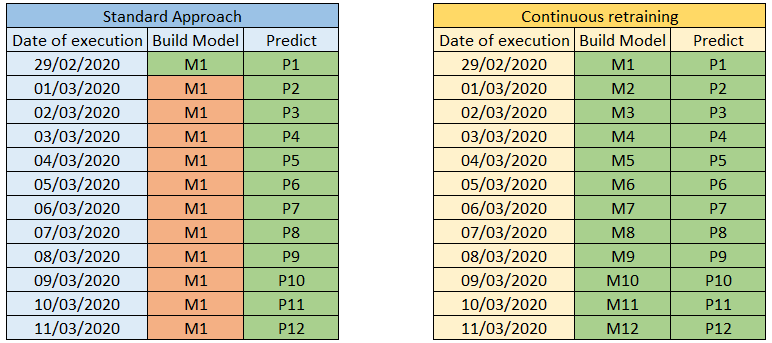

# 0. Setup

First we import the necessary libraries, helper functions and credentials to work with TIM through the Python Client.

In [1]:
from tim import Tim
import pandas as pd
import json
import numpy as np
import time
import datetime as dt
import copy
import plotly as plt
import plotly.express as px
import plotly.graph_objects as go
pd.set_option('mode.chained_assignment', None)
from IPython.display import clear_output

In [2]:
tim_credentials = json.load(open('tim_credentials.json'))
client = Tim(email=tim_credentials['email'],password=tim_credentials['password'])

### Helper Functions

In [3]:
def get_forecast_job_results_accuracy(response):   
    bin_json = response['bin']
    bin_accuracy_df = pd.DataFrame()
    for n in bin_json:
        bin_accuracy_df = pd.concat([bin_accuracy_df,pd.DataFrame(n).reset_index().rename(columns={'index':'KPI'})])
    bin_accuracy_df['accuracy_type'] = 'bin'

    samplesAhead_json = response['samplesAhead']
    samplesAhead_accuracy_df = pd.DataFrame()
    for n in samplesAhead_json:
        samplesAhead_accuracy_df = pd.concat([samplesAhead_accuracy_df,pd.DataFrame(n).reset_index().rename(columns={'index':'KPI'})])
    samplesAhead_accuracy_df['accuracy_type'] = 'samplesAhead'

    all_accuracy_df = pd.DataFrame(response['all']).reset_index().rename(columns={'index':'KPI'})
    all_accuracy_df['accuracy_type'] = 'all'
    id_columns = ['KPI','name','accuracy_type']
    acc_df = pd.concat([all_accuracy_df,samplesAhead_accuracy_df,bin_accuracy_df])
    df = pd.melt(acc_df, id_vars=id_columns, value_vars=list(set(acc_df.columns)-set(id_columns)))
    return df

def get_forecast_job_results_model(response):
    properties = response['model']['modelZoo']['variableProperties']
    models = response['model']['modelZoo']['models']
    
    pi_df = pd.DataFrame(properties).sort_values(by='importance',ascending=False)
    pi_df['rel_importance'] = pi_df['importance']/pi_df.sum()['importance']
    
    features = []
    for m in models:
        terms = m['terms']
        for count,t in enumerate(terms):
            f,b = find_feature(t['parts'])
            features.append([m['index'],count,f,t['importance'],b])
    fi_df = pd.DataFrame(features,columns=['Model','Term','Feature','importance','beta'])
    return pi_df,fi_df,models

def find_feature(sub_parts):
    dow_list = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    month_list = ['January','February','March','April','May','June','July','August','September','October','November','December']
    features_list = []
    for c,s in enumerate(sub_parts):
        if   s['type']=='β':
            sub_feature = ''
        elif s['type']=='TimeOffsets':
            sub_feature = s['predictor']+'(t'+str(s['offset'])+')'
        elif s['type']=='RestOfWeek':
            sub_feature ='DoW(t'+str(s['offset'])+') <= '+dow_list[s['day']-1]
        elif s['type']=='Intercept':
            sub_feature = 'Intercept('+str(int(s['value']))+')'
        elif s['type']=='Cos':
            sub_feature = 'Cos('+str(int(s['period']))+';'+s['unit']+')'
        elif s['type']=='Sin':
            sub_feature = 'Sin('+str(int(s['period']))+';'+s['unit']+')'
        elif s['type']=='ExponentialMovingAverage':
            sub_feature = 'EMA_'+s['predictor']+'(t'+str(int(s['offset']))+'; w='+str(int(s['window']))+')'
        elif s['type']=='Identity':
            sub_feature = s['predictor']
        elif s['type']=='PiecewiseLinear':
            sub_feature = 'max(0;'+str(s['subtype'])+'*('+str(round(s['knot'],6))+'-'+s['predictor']+'(t'+str(s['offset'])+')))'
        elif s['type']=='SimpleMovingAverage':
            sub_feature = 'SMA_'+s['predictor']+'(t'+str(int(s['offset']))+'; w='+str(int(s['window']))+')'
        elif s['type']=='Fourier':
            sub_feature = 'Fourier('+str(s['period'])+')'
        elif s['type']=='Weekday':
            sub_feature = 'DoW(t'+str(s['offset'])+') = '+dow_list[s['day']-1]
        elif s['type']=='Month':
            sub_feature = 'Month<='+month_list[s['month']]
        elif s['type']=='PublicHolidays':
            sub_feature = s['predictor']
        elif s['type']=='Trend':
            sub_feature = 'Trend'
        else:
            sub_feature = '_test_'
        if s['type']=='β':
            features_list.append(sub_feature)
            beta = s['value']
        else:
            features_list.append(' & '+sub_feature) if c>0 else features_list.append(sub_feature)
    feature_output = ''.join(str(e) for e in features_list)
    return feature_output,beta

def loop_timer(nb,length,start_dt,parameters):
    clear_output(wait=True)
    prg = nb/length
    now_dt = dt.datetime.now()
    rt = now_dt-start_dt
    etc = rt/prg-rt
    ert = rt+etc
    if "Nb processed" in parameters: print("Nb processed:",'\t',nb,"/",length,', Nb left',"("+str(length-nb)+")")
    if "Progress" in parameters: print("Progress:",'\t','{:.1%}'.format(prg))   
    if "Runtime" in parameters: print("Runtime:",'\t',str(rt)[:9])
    if "Individual" in parameters: print("Individual:",'\t',str(rt/nb)[:9])
    if "Est. Time" in parameters: print("Est. Time:",'\t',str(ert)[:9])
    if "Est. End" in parameters: print("Est. End:",'\t',str(now_dt+etc)[:19])
    if "Time left" in parameters: print("Time left:",'\t',str(etc)[:9])

# 1. Data Preparation

We load the energy, weather and holiday data to this notebook and combine them together into a table ready for analysis with TIM.

In [4]:
grid_df = pd.read_csv('belgian_grid_data.csv', low_memory=False)
weather_df = pd.read_csv('weather_data.csv', low_memory=False)
public_holidays_df = pd.read_csv('public_holidays.csv', low_memory=False)

In [5]:
tim_input_df = grid_df[['Timestamp','Quantity']].merge(weather_df,on='Timestamp',how='outer').merge(public_holidays_df,on='Timestamp',how='left')
for col in public_holidays_df.columns: tim_input_df[col] = tim_input_df[col].fillna(method='ffill')

In [6]:
timestamp = 'Timestamp'
target_variable = 'Quantity'
predictor_candidates = [s for s in list(tim_input_df.columns) if s not in [timestamp,target_variable]]
tim_input_df = tim_input_df[[timestamp,target_variable]+predictor_candidates].reset_index(drop=True)

This chart visualizes the raw data for TIM. We have more than 7 years of historical data from our sources. 

In [ ]:
v_data = tim_input_df.copy()
fig = plt.subplots.make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.02)
fig.add_trace(go.Scatter(x=v_data[timestamp], y=v_data[target_variable], name=target_variable), row=1, col=1)
for idx, p in enumerate(predictor_candidates):
    fig.add_trace(go.Scatter(x=v_data[timestamp], y=v_data[p], name=p), row=2, col=1)
fig.update_layout(height=600, width=1200, title_text="Data visualization")
fig.show()    

__Structural Change__  
To visualize the structural change, we group the data per year and month. In the graph you see for each year the average energy consumption per month.  
For 2020 we see a significant drop in March, April, May and June compare to the other years. In fact energy consumption dropped with 15% compare to the other years.  
This is the structural change that we are looking to analyze and see how TIM reacts to it.

In [8]:
grid_df['Year'] = pd.to_datetime(grid_df['Timestamp']).dt.year
grid_df['Month'] = pd.to_datetime(grid_df['Timestamp']).dt.month
grid_df['Day'] = pd.to_datetime(grid_df['Timestamp']).dt.day
grid_df['Hour'] = pd.to_datetime(grid_df['Timestamp']).dt.hour
per_year_df = grid_df.pivot(index=['Month','Day','Hour'], columns='Year', values='Quantity').reset_index()
monthly_df = per_year_df.groupby(['Month']).mean().reset_index()

In [ ]:
v_data = monthly_df.copy()
fig = go.Figure()
for y in range(2015,2022+1): fig.add_trace(go.Scatter(x=v_data.index, y=v_data[y], name=y))
fig.update_layout(height=600, width=1200, title_text="Monthly Consumption")
fig.show()  

# 2. Scenario Description

In our simulation we will replicate the following production scenario.
- Execution time: Everyday at 17:00 a new prediction is made
- Simulation Start: The first moment of execution is 2020-02-29 17:00
- Simulation End: The last moment of execution is 2020-04-29 17:00
- Simulation Horizon: There are 61 days of prediction executions being simulated.
- Forecasting horizon: At each execution we will forecast ahead sample 7 through 30. This will generate 24 predicted values for the next day ahead. (S+7 from 17:00 => 00:00 next day & S+30 from 17:00 => 23:00 next day) 
- Data Alignment: All predictor candidates are available for the entire forecasting horizon as weather forecasts and public holiday information.  
  
In short every day for two months we will forecast the day ahead at 17:oo. This replicates a real life scenario as Transmission System Operaters(TSO) would have to tackle.
We start at the end of February 2020. Two weeks before the first pandemic lockdown in Belgium. The lockdown in Belgium started around the 15th of March and that is also when the structural change appears in the data.
This simulation runs until the end of April to cover the effect of the structural change.

The cell below creates these simulated datasets by cutting the data of at the specific dates in the simulation horizon (taking into account data alignment).

In [10]:
start_history_dt = '2019-01-01 00:00:00'
simulation_start_dt = '2020-02-29 17:00'
simulation_end_dt = '2020-04-29 17:00'

forecast_datetimes = pd.date_range(start=simulation_start_dt,end =simulation_end_dt,freq="D")
# ---------------------- Upload ----------------------
fdt = forecast_datetimes[0]
f_fdt = fdt+dt.timedelta(hours=30)
merge_energy_df = grid_df[(grid_df['Timestamp']>=start_history_dt)&(grid_df['Timestamp']<=str(fdt))][['Timestamp','Quantity']]
merge_weather_df = weather_df[(weather_df['Timestamp']>=start_history_dt)&(weather_df['Timestamp']<=str(f_fdt))]
upload_tim_input_df = merge_energy_df.merge(merge_weather_df,on='Timestamp',how='outer').merge(public_holidays_df,on='Timestamp',how='left')
for col in public_holidays_df.columns: upload_tim_input_df[col] = upload_tim_input_df[col].fillna(method='ffill')
# ---------------------- Update ----------------------
update_datasets = []
for fdt in forecast_datetimes[1:]:
    f_fdt = fdt+dt.timedelta(hours=30)
    merge_energy_df = grid_df[(grid_df['Timestamp']>=start_history_dt)&(grid_df['Timestamp']<=str(fdt))][['Timestamp','Quantity']]
    merge_weather_df = weather_df[(weather_df['Timestamp']>=start_history_dt)&(weather_df['Timestamp']<=str(f_fdt))]
    tim_input_df = merge_energy_df.merge(merge_weather_df,on='Timestamp',how='outer').merge(public_holidays_df,on='Timestamp',how='left')
    for col in public_holidays_df.columns: tim_input_df[col] = tim_input_df[col].fillna(method='ffill')
    update_tim_input_df = tim_input_df.tail(24+30)
    update_datasets.append({'name':str(fdt),'dataset':update_tim_input_df})

# 2. Upload Data

In the next section you can upload the data for TIM to be analyzed or refer to already uploaded data.

### 2.1 Set up the data management workflow in TIM.

In [11]:
workspace_id = ''
dataset_name = 'structural_change'
dataset_upload_configuration = {"name": dataset_name,"workspace": {"id": workspace_id}}

### 2.2 Send the initial dataset to TIM.

In [12]:
# upload_dataset_response = client.upload_dataset(dataset = upload_tim_input_df,configuration = dataset_upload_configuration,wait_to_finish = True,handle_status_poll = print)
# upload_metadata = upload_dataset_response[0]
# upload_logs = upload_dataset_response[1]

In [13]:
# upload_dataset_id = upload_metadata['id']
# upload_dataset_version_id = upload_metadata['latestVersion']['id']
# tim_datasets =  {'name':dataset_name,'id':upload_dataset_id,'workspace': {'id': workspace_id},'versions':[{'name':str(forecast_datetimes[0]),'id':upload_dataset_version_id}]}
# with open('./Output/tim_datasets_'+dataset_name+'.json', 'w') as outfile: outfile.write(json.dumps(tim_datasets))

### 2.3 Send the dataset updates to TIM.

In [14]:
# length = len(update_datasets)
# start_dt = dt.datetime.now()
# for c,ud in enumerate(update_datasets):
#     clear_output(wait=True)
#     update_name = ud['name']
#     update_dataset = ud['dataset']
#     update_dataset_response = client.update_dataset(dataset_id = upload_dataset_id,dataset_version = update_dataset,configuration = {},wait_to_finish = False)
#     update_dataset_version_id = update_dataset_response['version']['id']
#     tim_datasets['versions'].append({'name':update_name,'id':update_dataset_version_id})
#     loop_timer(nb=c+1,length=length,start_dt=start_dt,parameters=['Nb processed','Progress','Runtime','Individual','Est. Time','Est. End','Time left'])
# dataset_version_ids = [f['id'] for f in tim_datasets['versions']]

### 2.4 Check the status of the dataset versions being uploaded.

In [15]:
# open_check = [1]
# idx = 0
# while (len(open_check)>0 and idx<=100):
#     clear_output(wait=True)
#     check_dataset_versions_response = client.get_dataset_versions(id = upload_dataset_id)
#     check_list = [resp for resp in check_dataset_versions_response if resp['id'] in dataset_version_ids]
#     open_check = list(set([cl['status'] for cl in check_list]).intersection(['Registered','Queued','Running']))
#     value_counter = {}
#     for cl in check_list:
#         v = cl['status']
#         if v not in value_counter: value_counter[v] = 0
#         value_counter[v] += 1
#     idx += 1
#     print(idx,value_counter)
#     if len(open_check)>0: time.sleep(2)

### 2.5 Load previously created datasets.

In [16]:
tim_datasets = json.load(open('./Output/tim_datasets_'+dataset_name+'.json'))

# 3. Set Up Experiments

For these experiments, we will use default settings for TIM. We only need to provide TIM with forecasting horizon. This setting wil then be combined with all the dataset versions previously uploaded to TIM.

In [17]:
# ------------------------------------------ Configurations ------------------------------------------
base = {
    "configuration": {
        "predictionTo": {"baseUnit": "Sample","value": 30},
        "predictionFrom": {"baseUnit": "Sample","value": 7},
        "backtest": "Production",
    },
    "data": {"version": {"id":"versionId"}}
}
# ------------------------------------------ TIM Settings ------------------------------------------
tim_settings = {
    "base": base,
}

Link the configurations to dataset versions

In [18]:
configuration_list = []
for td in tim_datasets['versions']:
    for ts in tim_settings:
        configuration = copy.deepcopy(tim_settings[ts])
        configuration['data']['version']['id']=td['id']
        configuration_name = ts+"_"+td['name']
        configuration_list.append({'configuration_name':configuration_name,'configuration':configuration,'tim_setting':ts,'dataset_version_name':td['name']})

Combine datases and configurations

In [19]:
ds_names = [dataset_upload_configuration['name']]
cf_names = [cf['configuration_name'] for cf in configuration_list]
experiment_list = [[c]+e for c,e in enumerate([[x,y] for x in ds_names for y in cf_names])]

Save (and load) the experiment list.

In [20]:
TIM_experiments = {'dataset_name': dataset_name, 'experiment_list':experiment_list}
with open('./Output/TIM_experiment_'+dataset_name+'.json', 'w') as outfile: outfile.write(json.dumps(TIM_experiments))
TIM_experiments = json.load(open('./Output/TIM_experiment_'+dataset_name+'.json'))
experiment_list = TIM_experiments['experiment_list']

In [21]:
experiment_df = pd.DataFrame(experiment_list,columns=['experiment_nb','dataset_name','configuration_name'])
experiment_df

,experiment_nb,dataset_name,configuration_name
0,0,structural_change,base_2020-02-29 17:00:00
1,1,structural_change,base_2020-03-01 17:00:00
2,2,structural_change,base_2020-03-02 17:00:00
3,3,structural_change,base_2020-03-03 17:00:00
4,4,structural_change,base_2020-03-04 17:00:00
...,...,...,...
56,56,structural_change,base_2020-04-25 17:00:00
57,57,structural_change,base_2020-04-26 17:00:00
58,58,structural_change,base_2020-04-27 17:00:00
59,59,structural_change,base_2020-04-28 17:00:00


# 4. Continuous Retraining

In this section we will simulate the continuous retraining and will use the Python client to execute all jobs in parallel. In real life these would be individual experiments being executed once a day and here we simulate all those at once.  
Once the jobs are executed we can collect the results from TIM and continue our analysis in this notebook.

## 4.1 Build Models

__Register & Execute the jobs.__

In [22]:
dataset_id = tim_datasets['id']
job_list = []
length = len(experiment_list)
start_dt = dt.datetime.now()
for c,exp in enumerate(experiment_list):
    clear_output(wait=True)
    configuration = [c for c in configuration_list if c['configuration_name'] in exp[2]][0]['configuration']
    response = client.build_forecasting_model_and_execute(dataset_id = dataset_id,job_configuration = configuration,wait_to_finish = False)
    job_list.append({'job_name':exp[0],'response':response['message'].replace("Forecast job ","").replace(" has been posted to queue.","")})
    loop_timer(nb=c+1,length=length,start_dt=start_dt,parameters=['Nb processed','Progress','Runtime','Individual','Est. Time','Est. End','Time left'])
job_ids = [u['response'] for u in job_list]

Nb processed: 	 61 / 61 , Nb left (0)
Progress: 	 100.0%
Runtime: 	 0:04:40.3
Individual: 	 0:00:04.5
Est. Time: 	 0:04:40.3
Est. End: 	 2022-07-08 14:16:25
Time left: 	 0:00:00


In [ ]:
open_check = [1]
idx = 0
while (len(open_check)>0 and idx<100):
    clear_output(wait=True)
    get_forecasting_jobs_response = client.get_forecasting_jobs(limit=1000)
    check_list = [resp for resp in get_forecasting_jobs_response if resp['id'] in job_ids]
    open_check = list(set([cl['status'] for cl in check_list]).intersection(['Registered','Queued','Running']))
    value_counter = {}
    for cl in check_list:
        v = cl['status']
        if v not in value_counter: value_counter[v] = 0
        value_counter[v] += 1
    idx += 1
    print("check",idx,value_counter)
    if len(open_check)>0: time.sleep(2)

In [73]:
start_dt = dt.datetime.now()
jobs_results = copy.deepcopy(job_list)
length=len(jobs_results)
for c,job in enumerate(jobs_results):
    clear_output(wait=True)
    try:
        get_forecast_results_response = client.get_forecast_results(forecast_job_id=job['response'])
        job['results'] = get_forecast_results_response
    except:
        pass
    loop_timer(nb=c+1,length=length,start_dt=start_dt,parameters=['Nb processed','Progress','Runtime','Individual','Est. Time','Est. End','Time left'])

Nb processed: 	 61 / 61 , Nb left (0)
Progress: 	 100.0%
Runtime: 	 0:06:02.8
Individual: 	 0:00:05.9
Est. Time: 	 0:06:02.8
Est. End: 	 2022-07-08 14:53:09
Time left: 	 0:00:00


## 4.2 Process Results

Prepare the output from TIM for visualization

In [74]:
all_results_df = pd.DataFrame()
all_properties_df = pd.DataFrame()
all_features_df = pd.DataFrame()
all_accuracy_df = pd.DataFrame()
for c,jr in enumerate(jobs_results):
    try:
        clear_output(wait=True)
        table_result = jr['results'][2]
        table_result['job_name'] = jr['job_name']
        all_results_df = pd.concat([all_results_df,table_result])

        properties_df,features_df,model = get_forecast_job_results_model(jr['results'][1])
        properties_df['job_name'] = jr['job_name']
        features_df['job_name'] = jr['job_name']
        all_properties_df = pd.concat([all_properties_df,properties_df])
        all_features_df = pd.concat([all_features_df,features_df])

        accuracy_df = get_forecast_job_results_accuracy(jr['results'][3])
        accuracy_df['job_name'] = jr['job_name']
        all_accuracy_df = pd.concat([all_accuracy_df,accuracy_df])
    except:
        pass
    print(c+1,"/",len(jobs_results))

61 / 61


Process the results from TIM.

In [75]:
experiment_results_df = all_results_df.merge(experiment_df.rename(columns={'experiment_nb':'job_name'}),on='job_name',how='left').merge(pd.DataFrame(configuration_list).drop(columns='configuration'),on='configuration_name',how='left')
experiment_properties_df = all_properties_df.merge(experiment_df.rename(columns={'experiment_nb':'job_name'}),on='job_name',how='left').merge(pd.DataFrame(configuration_list).drop(columns='configuration'),on='configuration_name',how='left')
experiment_features_df = all_features_df.merge(experiment_df.rename(columns={'experiment_nb':'job_name'}),on='job_name',how='left').merge(pd.DataFrame(configuration_list).drop(columns='configuration'),on='configuration_name',how='left')

Prepare the output from TIM for visualization

In [76]:
retrain_df = experiment_results_df[experiment_results_df['forecast_type']=='Production']

# 5. Standard Approach

In this section we will simulate the standard approach where 1 model is built and predictions are made using this model for the next two months. We will again use the Python Client to run this simulation in parallel and collect the results back to this notebook.

## 5.1 Build Model

This would be the same exercise as the first job executed in the Continuous retraining section. Since we already have these results we don't have to redo this calculation and simply fetch those results. This will then serve as the parent job for all following calculations.

In [78]:
build_forecasting_model_and_execute_response = jobs_results[0]['results']
metadata = build_forecasting_model_and_execute_response[0]
model_result = build_forecasting_model_and_execute_response[1]
table_result = build_forecasting_model_and_execute_response[2]
accuarcies = build_forecasting_model_and_execute_response[3]
logs = build_forecasting_model_and_execute_response[4]

## 5.2 Make Predictions

Again we will use default settings to make our predictions and link these settings to the dataset versions.

In [79]:
base_forecast = {
    "configuration": {
        "predictionTo": {"baseUnit": "Sample","value": 30},
        "predictionFrom": {"baseUnit": "Sample","value": 7},
    },
    "data": {"version": {"id": "versionId"}},
}

In [80]:
forecast_configuration_list = []
for td in tim_datasets['versions'][1:]:
    configuration = copy.deepcopy(base_forecast)
    configuration['data']['version']['id']=td['id']
    configuration_name = 'Forecast'+"_"+td['name']
    forecast_configuration_list.append({'configuration_name':configuration_name,'configuration':configuration,'tim_setting':'base_forecast','dataset_version_name':td['name']})

Send the execution requests to TIM. These jobs will now be calculated in parallel.

In [81]:
parent_job_id = job_list[0]['response']
forecast_job_list = []
length = len(forecast_configuration_list)
start_dt = dt.datetime.now()
for c,fc in enumerate(forecast_configuration_list):
    clear_output(wait=True)
    response = client.create_forecast_and_execute(parent_job_id = parent_job_id,job_configuration = fc['configuration'],wait_to_finish = False)
    forecast_job_list.append({'job_name':fc['configuration_name'],'response':response})
    loop_timer(nb=c+1,length=length,start_dt=start_dt,parameters=['Nb processed','Progress','Runtime','Individual','Est. Time','Est. End','Time left'])
forecast_job_ids = [u['response']['message'].replace("Forecast job ","").replace(" has been posted to queue.","") for u in forecast_job_list]

Nb processed: 	 60 / 60 , Nb left (0)
Progress: 	 100.0%
Runtime: 	 0:02:46.6
Individual: 	 0:00:02.7
Est. Time: 	 0:02:46.6
Est. End: 	 2022-07-08 14:59:12
Time left: 	 0:00:00


In [ ]:
open_check = [1]
idx = 0
while (len(open_check)>0 and idx<100):
    clear_output(wait=True)
    get_forecasting_jobs_response = client.get_forecasting_jobs(limit=1000)
    check_list = [resp for resp in get_forecasting_jobs_response if resp['id'] in forecast_job_ids]
    open_check = list(set([cl['status'] for cl in check_list]).intersection(['Registered','Queued','Running']))
    value_counter = {}
    for cl in check_list:
        v = cl['status']
        if v not in value_counter: value_counter[v] = 0
        value_counter[v] += 1
    idx += 1
    print("check",idx,value_counter)
    if len(open_check)>0: time.sleep(2)

Collect the results from TIM.

In [83]:
start_dt = dt.datetime.now()
forecast_jobs_results = copy.deepcopy(forecast_job_list)
length=len(forecast_jobs_results)
for c,job in enumerate(forecast_jobs_results):
    clear_output(wait=True)
    try:
        forecast_job_id = job['response']['message'].replace("Forecast job ","").replace(" has been posted to queue.","")
        job['results'] = client.get_forecast_results(forecast_job_id=forecast_job_id)
    except:
        pass
    loop_timer(nb=c+1,length=length,start_dt=start_dt,parameters=['Nb processed','Progress','Runtime','Individual','Est. Time','Est. End','Time left'])

Nb processed: 	 60 / 60 , Nb left (0)
Progress: 	 100.0%
Runtime: 	 0:06:16.4
Individual: 	 0:00:06.2
Est. Time: 	 0:06:16.4
Est. End: 	 2022-07-08 15:07:03
Time left: 	 0:00:00


## 5.3 Process Results

Prepare the output from TIM for visualization

In [84]:
all_forecast_results_df = pd.DataFrame()
for c,fj in enumerate(forecast_jobs_results):
    try:
        clear_output(wait=True)
        forecast_table_result = fj['results'][2]
        forecast_table_result['job_name'] = fj['job_name']
        all_forecast_results_df = pd.concat([all_forecast_results_df,forecast_table_result])
    except:
        pass
    print(c+1,"/",len(forecast_job_list))

60 / 60


In [85]:
standard_df = pd.concat([table_result[table_result['forecast_type']=='Production'],all_forecast_results_df])

# 6. Compare

Now that we have collected results from both the continuous retraining simulation as well as the standard approach. We can put both results next to actual values an compare the accuracy of the predictions over time.

In [86]:
retrain_df['compare'] = 'retrain'
standard_df['compare'] = 'standard'

actuals_df = tim_input_df[[timestamp,target_variable]].rename(columns={timestamp:'timestamp',target_variable:'target'})
actuals_df['timestamp'] = pd.to_datetime(actuals_df['timestamp'])

retrain_df['timestamp'] = pd.to_datetime(retrain_df['timestamp'],format='%Y-%m-%dT%H:%M:%S.%fZ')
standard_df['timestamp'] = pd.to_datetime(standard_df['timestamp'],format='%Y-%m-%dT%H:%M:%S.%fZ')
compare_df = pd.concat([retrain_df,standard_df])[['date_from','time_from','timestamp','forecast','model_index','samples_ahead','compare']].reset_index(drop=True).merge(actuals_df,on='timestamp',how='left')
compare_df['MAE'] = abs(compare_df['target']-compare_df['forecast'])
compare_df['MAPE'] = abs((compare_df['target']-compare_df['forecast'])/compare_df['target'])

compare_df['Cumulative_MAE'] = compare_df.groupby(['compare']).cumsum()['MAE']
structural_change_pivot_df = compare_df.pivot(index=['timestamp','target'], columns='compare', values=['forecast','MAE','Cumulative_MAE']).reset_index()
structural_change_pivot_df.columns = ['_'.join(col[::-1]).strip() for col in structural_change_pivot_df.columns.values]

These charts show the results of continuous retraining in green, and standard approach in red, next to the actual values in black. The Mean Absolute Error (MAE) indicates the delta between the predicted values and the actuals for both approaches and these MAE values are also visualized cumulatively to show which approach works better over time.

In [ ]:
v_data = structural_change_pivot_df.copy()
x_axis = '_timestamp'
colors = ['Green','Red']
fig = plt.subplots.make_subplots(rows=3, cols=1, vertical_spacing=0.02,shared_xaxes=True)
fig.add_trace(go.Scatter(x=v_data[x_axis], y=v_data['_target'], name='target', line=dict(color='black')), row=1, col=1)
for c,p in enumerate(["retrain","standard"]):
    try:
        fig.add_trace(go.Scatter(x=v_data[x_axis], y=v_data[p+'_forecast'], name=p+'_forecast', line=dict(color=colors[c])), row=1, col=1)
        fig.add_trace(go.Scatter(x=v_data[x_axis], y=v_data[p+'_MAE'], name=p+'_MAE', line=dict(color=colors[c])), row=2, col=1)
        fig.add_trace(go.Scatter(x=v_data[x_axis], y=v_data[p+'_Cumulative_MAE'], name=p+'_Cumulative_MAE', line=dict(color=colors[c])), row=3, col=1)
    except:
        pass
fig.update_layout(height=1000, width=1400, title_text="Simulation Results")
fig.show()

In [88]:
compare_df.groupby(['compare']).mean()[['MAE','MAPE']]

,MAE,MAPE
compare,,
retrain,225.864266,0.025825
standard,327.838485,0.037616


# 7. Insights

This visual shows over time the relative importance of each of the columns in our dataset that TIM has used.  
From this we can learn what information TIM is using and also see structural changes visualized from a model perspective.

In [ ]:
fig = plt.subplots.make_subplots(rows=1, cols=1, vertical_spacing=0.05)
for i,name in enumerate(experiment_properties_df['name'].unique()):
    trace_data = experiment_properties_df[(experiment_properties_df['name']==name)]
    fig.add_trace(go.Bar(x=trace_data['dataset_version_name'], y=trace_data['rel_importance'],name=str(ts)+"_"+str(name),marker_color=px.colors.qualitative.Plotly[int((i/10-np.floor(i/10))*10)]), row=1, col=1)
fig.update_layout(height=700, width=1400, title_text="Properties evolution",barmode='stack')
fig.show()

# 8. Conclusions

__1. Performance__  
  
The cumulative MAE clearly indicates that the continuous retraining approach clearly outperforms the standard approach from the moment the structural change happens (15th of March).  
This proves that to remain adaptable to structural changes you need to continuously retrain your model to avoid losses in accuracy.  
With TIM, continuous retraining is the default way of working and is therefore the best toolbox at your disposal for time series analysis and structurally changing environments.
  
__2. Insights__
  
The reason why this works can be derived from the insights. In the predictor importance evolution over time we clearly see that new patterns are being found in the data by TIM after the lockdown.  
With the standard approach we don't have that new information in our model at the moment that we need it and that is where the value of retraining becomes visible and explainable.

__3. Automation__
  
The key to unlocking better results in time series analysis is continuous retraining which is only feasible through automation of feature engineering and modeling building.  
And that is the innovation that TIM brings for time series analysis.